In [2]:
import dlib
import glob
import cv2
import os
import sys
import  time
import numpy as np
import matplotlib.pyplot as plt
import pyautogui as pyg
import shutil

## Step 1: Data Generation & Automatic Annotation.

Normally when you’re training a hand detector you’re going to need several images of the hand and then you’ll need to annotate them meaning you’ll have to draw bounding boxes over the hand in each image.

Automate the Annotation Process
A smarter way to go about is to automate this annotation process while you’re collecting training images.

How are we going to do that?

Well, all you need to do is use a sliding window, I’ve already explained what a sliding window is above.

Now what we’re going to do is put our hand inside the window and whenever the window moves we will move our hand with it, after that is done we will save that image and the window box will be our annotated box.

This way we will automate the annotation process. How cool is that.

The script below does just that, it saves the images in the folder named training_images and appends the window box locations in a python list.

Note: The Code above is structured in a way that when you run the code the second time it will append new images with the previous one, this is done so you can gather more samples at different places with different backgrounds, so you can have a diverse dataset. You can choose to delete all previous images by setting clear_images variable to True.

Before we move forward, you should also know that the detector we’re training is not a full-fledged hand detector but its actually a hand palm detector this is because a HOG + SVM model is not robust enough to capture the deformation of objects like a hand. If we were training a deep learning based detector then this wouldn’t be much of an issue but for this case make sure you’re not collecting images of deformed hands with different variations, make sure the palm is facing the camera.

In [20]:
# If cleanup is True then the new images and annotations will be appended to previous ones
# If False then all previous images and annotations will be deleted.
cleanup = True
 
# Set the window to a normal one so we can adjust it
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
 
# Resize the window and adjust it to the center
# This is done so we're ready for capturing the images.
cv2.resizeWindow('frame', 1920,1080)
cv2.moveWindow("frame", 0,0)
 
# Initialize webcam
cap = cv2.VideoCapture(0,cv2.CAP_DSHOW)
 
# Initalize sliding window's x1,y1
x1 ,y1 = 0,0
 
# These will be the width and height of the sliding window.
window_width = 190#140  
window_height = 190
 
# We will save images after every 4 frames
# This is done so we don't have lot's of duplicate images
skip_frames = 3
frame_gap = 0
 
# This is the directory where our images will be stored
# Make sure to change both names if you're saving a different Detector
directory = 'train_images_h'
box_file = 'boxes_h.txt'
 
# If cleanup is True then delete all images and bounding_box annotations.
if cleanup:
     
    # Delete the images directory if it exists
    if os.path.exists(directory):
        shutil.rmtree(directory)
     
    # Clear up all previous bounding boxes
    open(box_file, 'w').close()
     
    # Initialize the counter to 0
    counter = 0
     
elif os.path.exists(box_file):
 
    # If cleanup is false then we must append the new boxes with the old
    with open(box_file,'r') as text_file:
        box_content = text_file.read()
         
    # Set the counter to the previous highest checkpoint
    counter = int(box_content.split(':')[-2].split(',')[-1])
 
# Open up this text file or create it if it does not exists
fr = open(box_file, 'a')
 
# Create our image directory if it does not exists.
if not os.path.exists(directory):
   os.mkdir(directory)
 
# Initial wait before you start recording each row
initial_wait = 0
         
# Start the loop for the sliding window
while(True):
     
    # Start reading from camera
    ret, frame = cap.read()
    if not ret:
        break
         
    # Invert the image laterally to get the mirror reflection.
    frame = cv2.flip( frame, 1 )
     
    # Make a copy of the original frame
    orig = frame.copy()    
     
    # Wait the first 50 frames so that you can place your hand correctly
    if initial_wait > 60:
         
        # Increment frame_gap by 1.
        frame_gap +=1 
     
        # Move the window to the right by some amount in each iteration.    
        if x1 + window_width < frame.shape[1]:
            x1 += 4
            time.sleep(0.1)            
             
        elif y1 + window_height + 270 < frame.shape[1]:
 
            # If the sliding_window has reached the end of the row then move down by some amount.
            # Also start the window from start of the row
            y1 += 80   
            x1 = 0
 
            # Setting frame_gap and init_wait to 0.
            # This is done so that the user has the time to place the hand correctly
            # in the next row before image is saved.
            frame_gap = 0
            initial_wait = 0
             
        # Break the loop if we have gone over the whole screen.
        else:
            break
               
    else: 
        initial_wait += 1
 
    # Save the image every nth frame.
    if frame_gap == skip_frames:
 
        # Set the image name equal to the counter value
        img_name = str(counter)  + '.png'
 
        # Save the Image in the defined directory
        img_full_name = directory + '/' + str(counter) +  '.png'
        cv2.imwrite(img_full_name, orig)
         
        # Save the bounding box coordinates in the text file.
        fr.write('{}:({},{},{},{}),'.format(counter, x1, y1, x1+window_width, y1+window_height))
 
        # Increment the counter 
        counter += 1
 
        # Set the frame_gap back to 0.
        frame_gap = 0
 
    # Draw the sliding window
    cv2.rectangle(frame,(x1,y1),(x1+window_width,y1+window_height),(0,255,0),3)
     
    # Display the frame
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) == ord('q'):
                break
 
# Release camera and close the file and window
cap.release()
cv2.destroyAllWindows()
fr.close()

## Step 2: Preprocessing Data.

Before you start training you just need to load and preprocess the data (images and labels) slightly so they are in the required format.

First, we will extract all the image names from the images directory. Then we will use the indexes of those images to extract their associated bounding box. The bounding box will be converted to a dlib rectangle format and then the image and its box will be stored together in a dictionary in the format: index: (image, bounding_box) ... At the time of training, we will separate the images from bounding_boxes, for now, we’ll keep them together.

Note: You could get away by just reading in all images and labels directly from their locations in a list but it’s a bad practice since if you delete a single image from its directory after recording images. Then it would cause trouble. Ideally, you should get rid of any image in train_images directory before training if you feel it’s not right.

In [21]:
# In this dictionary our images and annotations will be stored.
data = {}
 
# Get the indexes of all images.
image_indexes = [int(img_name.split('.')[0]) for img_name in os.listdir(directory)]
 
# Shuffle the indexes to have random train/test split later on.
np.random.shuffle(image_indexes)
 
# Open and read the content of the boxes.txt file
f = open(box_file, "r")
box_content = f.read()
 
# Convert the bounding boxes to dictionary in the format `index: (x1,y1,x2,y2)` ...
box_dict =  eval( '{' +box_content + '}' )
 
# Close the file
f.close()
 
# Loop over all indexes
for index in image_indexes:
     
    # Read the image in memmory and append it to the list
    img = cv2.imread(os.path.join(directory, str(index) + '.png'))    
     
    # Read the associated bounding_box
    bounding_box = box_dict[index]
     
    # Convert the bounding box to dlib format
    x1, y1, x2, y2  = bounding_box
    dlib_box = [ dlib.rectangle(left=x1 , top=y1, right=x2, bottom=y2) ]
     
    # Store the image and the box together
    data[index] = (img, dlib_box)

Let’s also check the total number of images and boxes present.

In [22]:
print('Number of Images and Boxes Present: {}'.format(len(data)))

Number of Images and Boxes Present: 148


## Step 3: Display Images:

You can optionally choose to display images along with their bounding box, this way you can visualize if the boxes were drawn properly or not.

C:\Users\245970\AppData\Local\Temp\ipykernel_12204\1212856223.py:5: UserWarning: you are shuffling a 'dict' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(data)


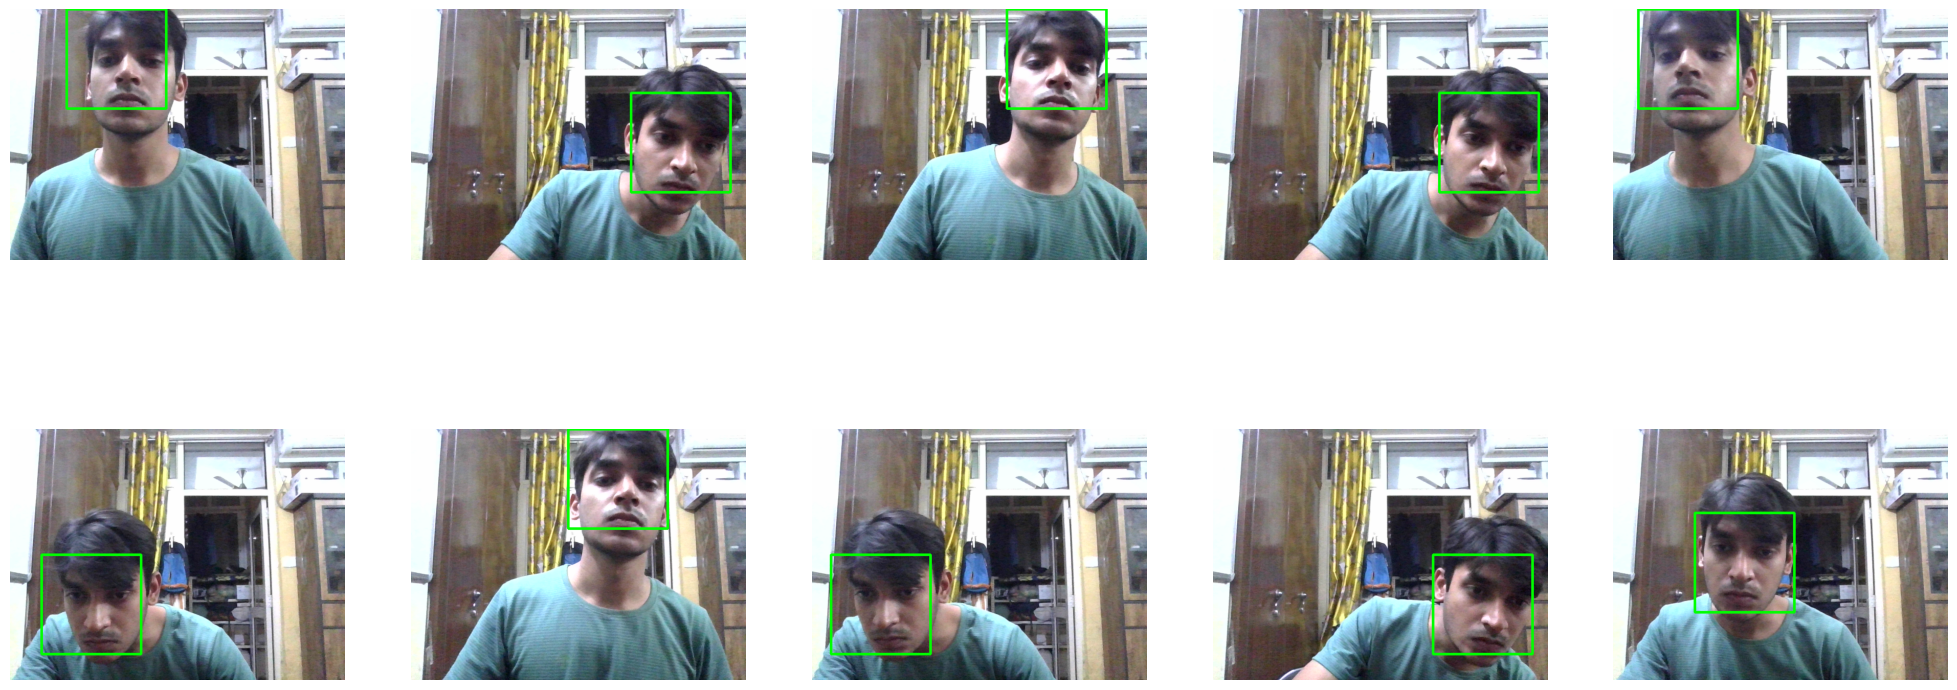

In [23]:
no_of_samples = 10
 
image_names = os.listdir(directory)
 
np.random.shuffle(data)
 
# Extract the subset of boxes
#subset = data[][:no_of_samples ]
 
cols = 5
 
# Given the number of samples to display, what's the number of rows required.
rows = int(np.ceil(no_of_samples / cols))
 
# Set the figure size
plt.figure(figsize=(cols*cols, rows*cols))
 
#Loop for each class
for i in range(no_of_samples):
         
        # Extract the bonding box coordinates
        d_box = data[i][1][0]
        left, top, right,bottom = d_box.left(), d_box.top(), d_box.right(), d_box.bottom()
         
        # Get the image
        image = data[i][0]
         
        # Draw reectangle on the detected hand
        cv2.rectangle(image,(left,top),(right,bottom),(0,255,0),3)
         
        # Display the image
        plt.subplot(rows,cols,i+1);plt.imshow(image[:,:,::-1]);plt.axis('off');

## Step 4: Train the Detector.

You can start training the detector by calling dlib.train_simple_object_detector and passing in a list of images and a list of associated dlib rectangles. First, we will extract the images and bounding box rectangles from our dictionary and then pass them to the training function.

Before you start training you can also specify some training options.

In [24]:
# This is the percentage of data we will use to train
# The rest will be used for testing
percent = 0.8
 
# How many examples make 80%.
split = int(len(data) * percent)
 
# Seperate the images and bounding boxes in different lists.
images = [tuple_value[0] for tuple_value in data.values()]
bounding_boxes = [tuple_value[1] for tuple_value in data.values()]
 
# Initialize object detector Options
options = dlib.simple_object_detector_training_options()
 
# I'm disabling the horizontal flipping, becauase it confuses the detector if you're training on few examples
# By doing this the detector will only detect left or right hand (whichever you trained on). 
options.add_left_right_image_flips = False
 
# Set the c parameter of SVM equal to 5
# A bigger C encourages the model to better fit the training data, it can lead to overfitting.
# So set an optimal C value via trail and error.
options.C = 5
 
# Note the start time before training.
st = time.time()
 
# You can start the training now
detector = dlib.train_simple_object_detector(images[:split], bounding_boxes[:split], options)
 
# Print the Total time taken to train the detector
print('Training Completed, Total Time taken: {:.2f} seconds'.format(time.time() - st))

Training Completed, Total Time taken: 16.74 seconds


## Step 5: Save & Evaluate the Detector
## Save The Trained Detector

You should now save the detector so you don’t have to train it again the next time you want to use it. The extension of the model is .svm as in Support Vector Machine.

In [25]:
file_name = 'Head_Detector.svm'
detector.save(file_name)

## Check the Hog Descriptor:

You can even check out the final hog descriptor from the code below, the descriptor should look something like the target object. After running this code a window will pop up.

In [26]:
win_det = dlib.image_window()
win_det.set_image(detector)

## Check Training Metrics

You can call dlib.test_simple_object_detector() to test your model on training data.

In [27]:
print("Training Metrics: {}".format(dlib.test_simple_object_detector(images[:split], bounding_boxes[:split], detector)))

Training Metrics: precision: 1, recall: 1, average precision: 1


## Check Testing Metrics:

Similarly, we can also check the testing metrics by using the remaining 20% of the data

In [28]:
print("Testing Metrics: {}".format(dlib.test_simple_object_detector(images[split:], bounding_boxes[split:], detector)))

Testing Metrics: precision: 1, recall: 1, average precision: 1


## Train the Final Detector

We trained the model on 80% of the data, if you’re satisfied with the metrics above then you now can retrain the detector on 100% of the data.

One thing you may have noted is that the precision of the model is pretty high, this is really good since we don’t want any false positives when we try to gesture control games.

In [29]:
detector = dlib.train_simple_object_detector(images, bounding_boxes, options)
detector.save(file_name)

## Step 6: Test the Trained Detector on Live Webcam.

Finally let’s test our detector. Now we’re going to do inference with our trained detector. You can load the detector by calling detector = dlib.simple_object_detector() After loading the detector you can pass in a frame by doing detector(frame) and it will return the bounding box location of the hand if it was detected.

In [31]:
file_name = 'D:\Computer Vision Masterclass\Hand_Detector.svm'
 
# Load our trained detector 
detector = dlib.simple_object_detector(file_name)
 
# Set the window name
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
 
# Initialize webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
 
# Setting the downscaling size, for faster detection
# If you're not getting any detections then you can set this to 1
scale_factor = 2.0
 
# Initially the size of the hand and its center x point will be 0
size, center_x = 0,0
 
# Initialize these variables for calculating FPS
fps = 0
frame_counter = 0
start_time = time.time()
 
# Set the while loop
while(True):
     
    # Read frame by frame
    ret, frame = cap.read()
     
    if not ret:
        break
     
    # Laterally flip the frame
    frame = cv2.flip( frame, 1 )
     
    # Calculate the Average FPS
    frame_counter += 1
    fps = (frame_counter / (time.time() - start_time))
     
    # Create a clean copy of the frame
    copy = frame.copy()  
     
    # Downsize the frame.
    new_width = int(frame.shape[1]/scale_factor)
    new_height = int(frame.shape[0]/scale_factor)
    resized_frame = cv2.resize(copy, (new_width, new_height))
     
    # Detect with detector
    detections = detector(resized_frame)
     
    # Loop for each detection.
    for detection in (detections):    
         
        # Since we downscaled the image we will need to resacle the coordinates according to the original image.
        x1 = int(detection.left() * scale_factor )
        y1 =  int(detection.top() * scale_factor )
        x2 =  int(detection.right() * scale_factor )
        y2 =  int(detection.bottom()* scale_factor )
         
        # Draw the bounding box
        cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0), 2 )
        cv2.putText(frame, 'Hand Detected', (x1, y2+20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255),2)
 
        # Calculate size of the hand. 
        size = int( (x2 - x1) * (y2-y1) )
         
        # Extract the center of the hand on x-axis.
        center_x = x2 - x1 // 2
     
    # Display FPS and size of hand
    cv2.putText(frame, 'FPS: {:.2f}'.format(fps), (20, 20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255),2)
 
    # This information is useful for when you'll be building hand gesture applications
    cv2.putText(frame, 'Center: {}'.format(center_x), (540, 20), cv2.FONT_HERSHEY_COMPLEX, 0.5, (233, 100, 25))
    cv2.putText(frame, 'size: {}'.format(size), (540, 40), cv2.FONT_HERSHEY_COMPLEX, 0.5, (233, 100, 25))
     
    # Display the image
    cv2.imshow('frame',frame)
                   
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
# Relase the webcam and destroy all windows
cap.release()
cv2.destroyAllWindows()

## Step 7: Using Multiple Object Detectors Together

Now if you wanted to train a detector on multiple classes and not just hands then unfortunately you can’t just do that. The only way to do that is to train multiple detectors and run them simultaneously, This of course will significantly reduce your speed.

There is a silver lining here which is that dlib comes with a function called dlib.fhog_object_detector.run_multiple() which allows you to run multiple object detectors simultaneously in an efficient way. Of course the more detectors you add, the slower your code gets. This method also gives you confidence scores for each detection.

Here’s an example of me using two detectors One is trained on my hand and one on my face

In [32]:
# Load our trained detector 
detector = dlib.simple_object_detector(file_name)
 
# Set the window to normal
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
 
# Initialize webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
 
# Setting the downscaling size, for faster detection
# If you're not getting any detections then you can set this to 1
scale_factor = 2.0
 
# Initially the size of the hand and its center x point will be 0
size, center_x = 0,0
 
# Initialize these variables for calculating FPS
fps = 0
frame_counter = 0
start_time = time.time()
 
# load up all the detectors using this function.
hand_detector = dlib.fhog_object_detector("Hand_Detector.svm")
head_detector = dlib.fhog_object_detector("Head_Detector.svm") 
 
# Now insert all detectors in a list
detectors = [hand_detector, head_detector]
 
# Create a list of detector names in the same order
names = ['Hand Detected', 'Head Detected']
 
# Set the while loop
while(True):
     
    # Read frame by frame
    ret, frame = cap.read()
     
    if not ret:
        break
     
    # Laterally flip the frame
    frame = cv2.flip( frame, 1 )
     
    # Calculate the Average FPS
    frame_counter += 1
    fps = (frame_counter / (time.time() - start_time))
     
    # Create a clean copy of the frame
    copy = frame.copy()  
     
    # Downsize the frame.
    new_width = int(frame.shape[1]/scale_factor)
    new_height = int(frame.shape[0]/scale_factor)
    resized_frame = cv2.resize(copy, (new_width, new_height))
     
    # Perform the Detection
    # Beside's boxes you will also get confidence scores and ID's of the detector
    [detections, confidences, detector_idxs] = dlib.fhog_object_detector.run_multiple(detectors, resized_frame, 
    upsample_num_times=1)
     
    # Loop for each detected box
    for i in range(len(detections)):    
         
        # Since we downscaled the image we will need to resacle the coordinates according to the original image.
        x1 = int(detections[i].left() * scale_factor )
        y1 =  int(detections[i].top() * scale_factor )
        x2 =  int(detections[i].right() * scale_factor )
        y2 =  int(detections[i].bottom()* scale_factor )
         
        # Draw the bounding box with confidence scores and the names of the detector
        cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0), 2 )
        cv2.putText(frame, '{}: {:.2f}%'.format(names[detector_idxs[i]], confidences[i]*100), (x1, y2+20), 
        cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255),2)
 
        # Calculate size of the hand. 
        size = int( (x2 - x1) * (y2-y1) )
         
        # Extract the center of the hand on x-axis.
        center_x = int(x1 + (x2 - x1) / 2)
     
    # Display FPS and size of hand
    cv2.putText(frame, 'FPS: {:.2f}'.format(fps), (20, 20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255),2)
 
    # This information is useful for when you'll be building hand gesture applications
    cv2.putText(frame, 'Center: {}'.format(center_x), (540, 20), cv2.FONT_HERSHEY_COMPLEX, 0.5, (233, 100, 25))
    cv2.putText(frame, 'size: {}'.format(size), (540, 40), cv2.FONT_HERSHEY_COMPLEX, 0.5, (233, 100, 25))
     
    # Display the image
    cv2.imshow('frame',frame)
                   
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
# Relase the webcam and destroy all windows
cap.release()
cv2.destroyAllWindows()

## Integrating Gesture controls with Applications.

Now that we have learned how to train a single and multi Object Detector, let’s move onto the fun part where we automate a game and a video player via hand gestures.

First, I’ll control the VLC media player to pause/play or move forward/backward in the video. Then using the same code I’ll control a clone of the infamous temple run game.

Well, it’s pretty simple, We are going to use the pyautogui library. This library allows you to control keyboard buttons and mouse cursor programmatically. You can learn more about this library here.

So now we’ll make a program that when we move our hand to the left of the screen pyautogui will press the left arrow key and when the hand is moved to the right, the right arrow key is pressed.

Similarly, If our hand is closer to the screen we’ll want to press the Up button and the hand is further from the screen we’ll want to press the down button.

This can easily be accomplished by measuring the size of the bounding box of the hand. As the size increases or decreases when the hand moves closer or far from the camera.

## Tuning Our Distance Thresholds:

Before we start controlling the game, we need to visualize how the buttons will be triggered, and if our defined thresholds are correct. This script draws lines between thresholds and displays the buttons that should be pressed. If these default thresholds don’t work for you then Change them, especially the size_up_th and size_down_th.

In [33]:
# Set these thresholds accordingly.
 
# If hand size is larger than this then up, button is triggered
size_up_th = 80000
 
# If hand size is smaller than this then down key is triggered
size_down_th = 25000
 
# If the center_x location is less than this then left key is triggered
left = 160
 
# If the center_x location is greater than this then right key is triggered
right = 480
 
# Load our trained detector 
detector = dlib.simple_object_detector('Hand_Detector.svm')
 
# Set the window to normal
cv2.namedWindow('frame', cv2.WINDOW_NORMAL)
 
# Initialize webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
 
# Setting the downscaling size, for faster detection
# If you're not getting any detections then you can set this to 1
scale_factor = 2.0
 
# Initially the size of the hand and its center x point will be 0
size, center_x = 0,0
 
# Initialize these variables for calculating FPS
fps = 0
frame_counter = 0
start_time = time.time()
 
# Set the while loop
while(True):
     
    # Read frame by frame
    ret, frame = cap.read()
     
    if not ret:
        break
     
    # Laterally flip the frame
    frame = cv2.flip( frame, 1 )
     
    # Calculate the Average FPS
    frame_counter += 1
    fps = (frame_counter / (time.time() - start_time))
     
    # Create a clean copy of the frame
    copy = frame.copy()  
     
    # Downsize the frame.
    new_width = int(frame.shape[1]/scale_factor)
    new_height = int(frame.shape[0]/scale_factor)
    resized_frame = cv2.resize(copy, (new_width, new_height))
     
    # Detect with detector
    detections = detector(resized_frame)
     
    # Set Default values
    text = 'No Hand Detected'
    center_x = 0
    size = 0
 
    # Loop for each detection.
    for detection in (detections):    
         
        # Since we downscaled the image we will need to resacle the coordinates according to the original image.
        x1 = int(detection.left() * scale_factor )
        y1 =  int(detection.top() * scale_factor )
        x2 =  int(detection.right() * scale_factor )
        y2 =  int(detection.bottom()* scale_factor )
         
        # Calculate size of the hand. 
        size = int( (x2 - x1) * (y2-y1) )
         
        # Extract the center of the hand on x-axis.
        center_x = int(x1 + (x2 - x1) / 2)
         
        # Draw the bounding box of the detected hand
        cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0), 2 )
         
        # Now based on the size or center_x location set the required text
        if center_x > right:
            text = 'Right'
 
        elif center_x < left:
            text = 'Left'
 
        elif size > size_up_th:
            text = 'Up'
 
        elif size < size_down_th:
            text = 'Down'
             
        else:
            text = 'Neutral'
             
    # Now we should draw lines for left/right threshold
    cv2.line(frame, (left,0),(left, frame.shape[0]),(25,25,255), 2)
    cv2.line(frame, (right,0),(right, frame.shape[0]),(25,25,255), 2)    
 
    # Display Center_x value and size.
    cv2.putText(frame, 'Center: {}'.format(center_x), (500, 20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (233, 100, 25), 1)
    cv2.putText(frame, 'size: {}'.format(size), (500, 40), cv2.FONT_HERSHEY_COMPLEX, 0.6, (233, 100, 25))
 
    # Finally display the text showing which key should be triggered
    cv2.putText(frame, text, (220, 30), cv2.FONT_HERSHEY_COMPLEX, 0.7, (33, 100, 185), 2)
 
    # Display the image
    cv2.imshow('frame',frame)
 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
 
# Relase the webcam and destroy all windows
cap.release()
cv2.destroyAllWindows()

## Main Function

This is our main script which will control the keyboard keys based on the hand movement. Now with this script I’ve controlled both the temple run game and the VLC media player.

When controlling the media player I make the variable player = True

In [34]:
# Load our trained detector 
detector = dlib.simple_object_detector('Hand_Detector.svm')
 
# Initialize webcam
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
 
# Setting the downscaling size, for faster detection
# If you're not getting any detections then you can set this to 1
scale_factor = 2.0
 
# Initially the size of the hand and its center x point will be 0
size, center_x = 0,0
 
# Initialize these variables for calculating FPS
fps = 0
frame_counter = 0
start_time = time.time()
 
# Set Player = True in order to use this script for the VLC video player
player = True
 
# This variable is True when we press a key and False when there is no detection.
# It's only used in the video Player
status = False
 
# We're recording the whole screen to view it later
screen_width, screen_height = tuple(pyg.size())
out = cv2.VideoWriter(r'videorecord.mp4', cv2.VideoWriter_fourcc(*'XVID'), 15.0, (screen_width,screen_height ))
 
# Set the while loop
while(True):
     
    try:
     
        # Read frame by frame
        ret, frame = cap.read()
 
        if not ret:
            break
 
        # Laterally flip the frame
        frame = cv2.flip( frame, 1 )
 
        # Calculate the Average FPS
        frame_counter += 1
        fps = (frame_counter / (time.time() - start_time))
 
        # Create a clean copy of the frame
        copy = frame.copy()  
 
        # Downsize the frame.
        new_width = int(frame.shape[1]/scale_factor)
        new_height = int(frame.shape[0]/scale_factor)
        resized_frame = cv2.resize(copy, (new_width, new_height))
 
        # Detect with detector
        detections = detector(resized_frame)
         
        # Key will initially be None
        key = None
 
        if len(detections) > 0:
             
            # Grab the first detection
            detection = detections[0]
 
            # Since we downscaled the image we will need to resacle the coordinates according to the original image.
            x1 = int(detection.left() * scale_factor )
            y1 =  int(detection.top() * scale_factor )
            x2 =  int(detection.right() * scale_factor )
            y2 =  int(detection.bottom()* scale_factor )
             
            cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0), 2 )
            cv2.putText(frame, 'Hand Detected', (x1, y2+20), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 0, 255),2)
 
            # Calculate size of the hand. 
            size = int( (x2 - x1) * (y2-y1) )
 
            # Extract the center of the hand on x-axis.
            center_x = int(x1 + (x2 - x1) / 2)
 
            # Press the required button based on center_x location and size   
            # The behavior of keys will be different depending upon if we're controlling a game or a video player.
            # The status variable makes sure we do not double press the key in case of a video player.
 
            if center_x > right:
                 
                key = 'right'
                if player and not status:
                    pyg.hotkey('ctrl', 'right') 
                    status = True
 
            elif center_x < left:
                 
                key = 'left'              
                if player and not status:
                    pyg.hotkey('ctrl', 'left')
                    status = True
 
            elif size > size_up_th:
                 
                key = 'up'
                if player and not status:
                    pyg.press('space')
                    status = True
 
            elif size < size_down_th:
                key = 'down'
             
            # Check if we're playing a game then press the required key
            if key is not None and player == False:                
                    pyg.press(key)            
         
        # If there wasn't a detection then the status is made False
        else:
            status = False
         
         
        # Capture the screen
        image = pyg.screenshot()
         
        # Convert to BGR, numpy array (Opencv format of image)
        img = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
         
        # Resize the camera frame and attach it to screen.
        resized_frame = cv2.resize(frame, (0,0), fx=0.6, fy=0.6)
        h = resized_frame.shape[0]
        w = resized_frame.shape[1]
        img[0:h, 0:w]  = resized_frame
         
        # Save the video frame
        out.write(img)
         
        #time.sleep(0.2)
    except KeyboardInterrupt:
        print('Releasing the Camera and exiting since the program was stopped')
        cap.release()
        out.release()
        sys.exit()

Releasing the Camera and exiting since the program was stopped


SystemExit: 

c:\ProgramData\miniconda3\envs\vision\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
